## Advantage actor-critic with AgentNet
#### BipedalWalker-v2

In [1]:
# %env THEANO_FLAGS=device=gpu0
# %env THEANO_FLAGS='floatX=float32'
# import os
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
#     !bash ../xvfb start
#     %env DISPLAY=:1
        
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import gym

# env = gym.make("MountainCar-v0").env
env = gym.make("BipedalWalker-v2").env
print(env.action_space)
obs = env.reset()
state_size = len(obs)
actions_dim = env.action_space.shape[0]
print(actions_dim)
print(env.action_space)
print(obs.shape)
print(state_size)
x = env.action_space.sample()
x

INFO:gym.envs.registration:Making new env: BipedalWalker-v2
[2017-11-15 22:45:25,282] Making new env: BipedalWalker-v2


Box(4,)
4
Box(4,)
(24,)
24


array([ 0.09762701,  0.43037873,  0.20552675,  0.08976637])

In [3]:
n_split = 3
n_actions = n_split ** actions_dim
# actions_grid = 
def id_to_action(idx):
    indices = []
    for i in range(actions_dim):
        indices.append(idx % n_split)
        idx = idx // n_split
    return np.array([ ((2.0 / (n_split - 1.0) * i) - 1.0) * 0.8 for i in indices])

class MyEnv(gym.envs.box2d.bipedal_walker.BipedalWalker):
    def __init__(self, source=None):
        if source is not None:
            self.__dict__.update(source.__dict__)
        self.action_space.sample = lambda : np.random.randint(0,n_actions)
        
    def step(self, action):
        action = id_to_action(action)
        return super(MyEnv, self).step(action)
    
def my_make():
    return MyEnv(gym.make("BipedalWalker-v2").env)

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [4]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer,NonlinearityLayer,batch_norm,dropout

observation_layer = InputLayer((None,state_size))
hidden_layer_1 = DenseLayer(observation_layer,num_units=128,nonlinearity=lasagne.nonlinearities.tanh)
nn = DenseLayer(hidden_layer_1, num_units=128, nonlinearity=lasagne.nonlinearities.tanh)
# nn = DenseLayer(hidden_layer_2,num_units=64,nonlinearity=lasagne.nonlinearities.tanh)


In [5]:
policy_layer = DenseLayer(nn,n_actions, nonlinearity=lasagne.nonlinearities.softmax)

#a layer that predicts V-state-values
V_layer = DenseLayer(nn, 1, nonlinearity=None)

In [6]:
#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)
# action_layer = policy_layer

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [7]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(policy_layer, V_layer),
              action_layers=action_layer)


In [8]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((action_layer,V_layer),trainable=True)
weights

[W, b, W, b, W, b, W, b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [9]:
from gym.wrappers.time_limit import TimeLimit

class env_wrapper(object):
    def __init__(self, name, t_max):
        self.name = name
        self.t_max = t_max
    def __call__(self):
        env = my_make()
        env = TimeLimit(env, max_episode_steps=self.t_max)
        return env

In [10]:
from agentnet.experiments.openai_gym.pool import EnvPool

#create a small pool with 10 parallel agents
# pool = EnvPool(agent,make_env=env_wrapper("BipedalWalker-v2", 100), n_games=70,max_size=100)
pool = EnvPool(agent,make_env=env_wrapper("BipedalWalker-v2", 10000), n_games=70,max_size=1000)

#we assume that pool size 1000 is small enough to learn "almost on policy" :)

INFO:gym.envs.registration:Making new env: BipedalWalker-v2
[2017-11-15 22:45:32,767] Making new env: BipedalWalker-v2
INFO:gym.envs.registration:Making new env: BipedalWalker-v2
[2017-11-15 22:45:32,788] Making new env: BipedalWalker-v2
INFO:gym.envs.registration:Making new env: BipedalWalker-v2
[2017-11-15 22:45:32,811] Making new env: BipedalWalker-v2
INFO:gym.envs.registration:Making new env: BipedalWalker-v2
[2017-11-15 22:45:32,831] Making new env: BipedalWalker-v2
INFO:gym.envs.registration:Making new env: BipedalWalker-v2
[2017-11-15 22:45:32,860] Making new env: BipedalWalker-v2
INFO:gym.envs.registration:Making new env: BipedalWalker-v2
[2017-11-15 22:45:32,895] Making new env: BipedalWalker-v2
INFO:gym.envs.registration:Making new env: BipedalWalker-v2
[2017-11-15 22:45:33,011] Making new env: BipedalWalker-v2
INFO:gym.envs.registration:Making new env: BipedalWalker-v2
[2017-11-15 22:45:33,039] Making new env: BipedalWalker-v2
INFO:gym.envs.registration:Making new env: Biped

In [11]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(100)


print(action_log[-1])
print(reward_log[-1])

[67 52 30 33 48 74  9 28 42 61 42 20 51 53 76 14 72  6 36 46 50 62 65 25 24
 42  7 51 49 26 41 37  6 13 38 53 63 38 61 76 64 21 24 74  6 62 57 35  5 25
 24  9 62  7 22 28 17 67 40 21 38 25 37  0 68 43 40 57 18 10 47 43 25 28 45
 22 71 48 76 19 39 39 29 22 65 68 15 11 27 55 58 13 21 36  2 25 40 67 28 63]
[-0.04619203 -0.10107717 -0.01672756 -0.19534437 -0.12329829 -0.04215239
 -0.08300313 -0.11362829 -0.11727923 -0.1958777  -0.15217591 -0.07448169
 -0.08268763 -0.02679145  0.04999613  0.04643353  0.00218114 -0.10863018
 -0.12751184 -0.08533372 -0.03438163 -0.08036722 -0.01228772  0.03016658
 -0.02801861 -0.04682118 -0.13177818 -0.13387919 -0.04899081 -0.04278532
  0.07961984  0.08007367 -0.11228171 -0.04321401 -0.00663938  0.05888262
 -0.02507907  0.0495117  -0.04268523  0.04149332  0.03942493  0.01844512
 -0.00372064  0.05778675 -0.0569953  -0.0620785  -0.09737351 -0.10142639
 -0.10107138 -0.04076763 -0.06213505 -0.10120242 -0.13088206 -0.1679784
 -0.08541628 -0.17589118 -0.14621177 -0

In [12]:
SEQ_LENGTH = 30
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Actor-critic loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [13]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)

_,_,_,_,(policy_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [14]:
replay.actions

[AdvancedSubtensor1.0]

In [15]:
from agentnet.learning import a2c                                                   

elwise_mse_loss = a2c.get_elementwise_objective(policy_seq,
                                                V_seq[:,:,0],
                                                replay.actions[0],
                                                replay.rewards,
                                                replay.is_alive,
                                                gamma_or_gammas=0.95,
                                                n_steps=1)

# print(elwise_mse_loss)
#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

loss += 0.0001*(1./(policy_seq)).sum(-1).mean()

In [16]:
# Compute weight updates
updates = lasagne.updates.rmsprop(loss, weights, learning_rate=10e-5)

In [17]:
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [18]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
# untrained_reward = pool.evaluate(save_path="./records",record_video=False)

#video is in the ./records folder

# Training loop


In [19]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}

In [ ]:
import tqdm
from IPython.display import clear_output

INFO:gym.envs.registration:Making new env: BipedalWalker-v2
[2017-11-15 23:52:13,939] Making new env: BipedalWalker-v2
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-15 23:52:13,958] Clearing 2 monitor files from previous run (because force=True was provided)
INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW6(RL)/records')
[2017-11-15 23:52:19,485] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/alex/Desktop/7sem/ML-mipt/ML_MIPT_2017_2/HW/HW6(RL)/records')


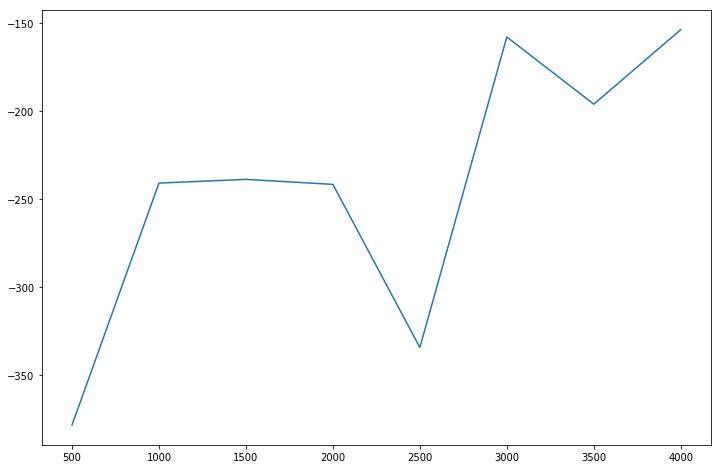

Current score(mean over 10) = -153.564
iter=4100	reward/step=-0.07386	loss ma=1.90365

In [ ]:
#the loop may take eons to finish.
#consider interrupting early.
loss = 0
for i in tqdm.tnrange(50000):    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    loss = loss*0.99 + train_step()*0.01
        
    
    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        print("iter=%i\treward/step=%.5f\tloss ma=%.5f"%(epoch_counter,
                                                        pool_mean_reward,
                                                        loss))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        clear_output(True)

        n_games = 10
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,
                                               verbose=False)
        iters,session_rewards=zip(*sorted(rewards.items(),key=lambda kv:kv[0]))
        mean_rewards = [np.mean(x) for x in session_rewards]
        plt.figure(figsize=(12, 8))
        plt.plot(iters, mean_rewards)
        plt.show() 
        if np.mean(rewards[epoch_counter]) > -105:
            break
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
        
    
    epoch_counter  +=1

    
# Time to drink some coffee!

In [22]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda kv:kv[0]))

TypeError: object of type 'map' has no len()

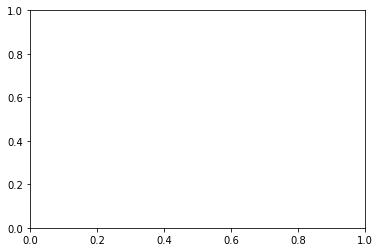

In [23]:
plt.plot(iters,map(np.mean,session_rewards))

In [ ]:
pool = EnvPool(agent,make_env="MountainCar-v0", 
               n_games=1,
               max_size=1000) 
pool.evaluate(record_video=False,
              n_games=10000, 
              verbose=False)

In [ ]:
# gym.upload('/home/common/nexes/Practical_RL/week6/records',
#            api_key="")
